In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16
#plt.rcParams["text.fontsize"] = 16


#plt.style.use(hep.style.ROOT)

### User Defined

In [2]:
#random trigger data
ptrigDF = pd.read_pickle(r'./PTRIG_LG50_HG50_4k_R28.pkl')
#beam data
df = pd.read_pickle(r'./BEAM_LG50_HG50_4k_R27.pkl')
#set to 1 for 4k files, 2 for 8k files
ADCmult = 1

#All hits below this threshold are set to zero
MIPCut = 0.3

#Apply MIP scaling and pedestal ADC value here for simulation

#ADCs per MIP for simulation, set to 1 if the file is in units of MIPs
ADCtoMIP = 1

#Pedestal value for simulation, in whatever units the file is in
SimPedestal = 0


simPedMeans = np.full(40, SimPedestal)
simMips = np.full(40, ADCtoMIP)

In [3]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
#fig, axs=plt.subplots(4, 10, figsize=(0.5*len(ptrigDF.columns),15),sharey=True,sharex=True)

pedMeans = []
pedStds = []

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


for i in range(round(len(df.columns)/2)):

    #plt.sca(axs[i%4][i//4])

    hist, bin_edges = np.histogram(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))),range=(0,100),bins=100)
   
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    
    p0 = [max(hist), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 3.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    #hist_fit = gauss(np.linspace(0,100,5000), *coeff)
    #plt.errorbar(bin_centres, y=hist, yerr=np.sqrt(hist),fmt='o')
    #plt.plot(np.linspace(0,100,5000), hist_fit, label='$\mu$=%2.0f Chs, \n$\sigma=$%2.0f Chs'%(coeff[1],abs(coeff[2])))
 
    pedMeans.append(coeff[1])

    pedStds.append(abs(coeff[2]))

    #plt.xlabel("ADC Units")
    #plt.ylabel("Counts")
  
    #plt.title("LG Ch {}".format("{:02d}".format(i)))
    #plt.tight_layout()
    #plt.legend(fontsize=17,loc='upper right')

Average mean value:
59.97515895659482
Average width value:
3.160664721284907


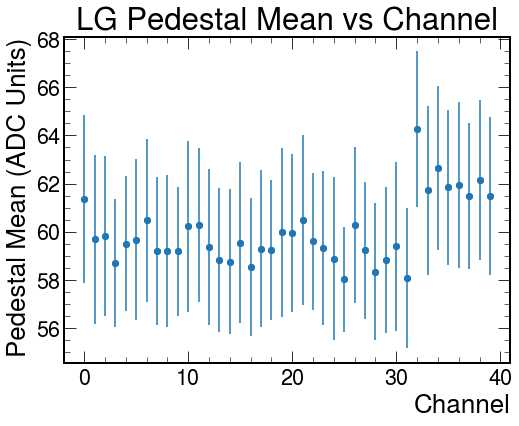

In [4]:
#plot pedestals means and stds for low gain

fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,40),pedMeans)
plt.xlabel('Channel')
plt.ylabel('Pedestal Mean (ADC Units)')
plt.title("LG Pedestal Mean vs Channel")
plt.errorbar(range(0,40), pedMeans, yerr=pedStds, fmt="o")
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))

In [5]:
def calibrate_dataframe(df, mips, pedMeans):
    # Create a new numpy array with the same shape as the dataframe
    new_array = np.zeros_like(df.values)

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Calculate the new values using the formula
            new_values = (df[col_name].values - pedMeans[int(ch)]) / mips[int(ch)]

            # Set values less than the MIPCut to 0
            new_values[new_values < MIPCut] = 0

            # Store the updated values in the corresponding column of new_array
            new_array[:, col_idx] = new_values

    # Create a new dataframe from the new numpy array with only LG columns
    lg_columns = [col for col in df.columns if col.endswith('_LG')]
    calibrated_df = pd.DataFrame(new_array[:, df.columns.isin(lg_columns)], columns=lg_columns, index=df.index)
    
    # Set dead channel values to 0
    calibrated_df['Ch_01_LG'] = 0.0
    calibrated_df['Ch_07_LG'] = 0.0
    
    return calibrated_df

def only_lowgain(df):
    # Create a new numpy array with the same shape as the dataframe
    new_array = np.zeros_like(df.values)

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Calculate the new values using the formula
            new_values = df[col_name].values

            # Store the updated values in the corresponding column of new_array
            new_array[:, col_idx] = new_values

    # Create a new dataframe from the new numpy array with only LG columns
    lg_columns = [col for col in df.columns if col.endswith('_LG')]
    onlyLG_df = pd.DataFrame(new_array[:, df.columns.isin(lg_columns)], columns=lg_columns, index=df.index)
    
    return onlyLG_df

def calculate_channel_sums(df, channel_numbers):
    # Get the values corresponding to the channel numbers as a NumPy array
    selected_values = df.iloc[:, channel_numbers].values

    # Calculate the sum along the channel axis
    channel_sums = np.sum(selected_values, axis=1)

    return channel_sums

def get_layer_positions(in_df, option):
    # Define the channel positions for each layer
    channel_positions = np.array([[-4.74/2, 4.74/2], [4.74/2, 4.74/2], [-4.74/2, -4.74/2], [4.74/2, -4.74/2]])
    
    # Get the number of events and layers
    num_events = len(in_df)
    num_layers = 10
    
    # Extract the layer channels from the DataFrame
    layer_channels = np.array(in_df.iloc[:, :40]).reshape(num_events, num_layers, 4)
    
    # Calculate the total energy for each layer
    total_energy = np.sum(layer_channels, axis=2)
    
    # Calculate the energy-weighted positions for each layer
    weighted_positions = np.sum(layer_channels[:, :, :, np.newaxis] * channel_positions, axis=2) / total_energy[:, :, np.newaxis]
    
    # Create a new DataFrame with the energy-weighted positions
    positions_df = pd.DataFrame({'X_Positions': weighted_positions[:, :, 0].tolist(), 'Y_Positions': weighted_positions[:, :, 1].tolist()})
    
    # Initialize a 2D list to store the layer positions
    layer_positions = [[] for _ in range(num_layers)]
    
    # Determine which option to use ('x' or 'y')
    if option == 'x':
        positions_column = 'X_Positions'
    elif option == 'y':
        positions_column = 'Y_Positions'
    else:
        raise ValueError("Invalid option. Please choose 'x' or 'y'.")
    
    # Iterate over the rows in the positions column
    for row in positions_df[positions_column]:
        # Iterate over the layers and append the corresponding position to the layer list
        for layer_idx, position in enumerate(row):
            layer_positions[layer_idx].append(position)
    
    return np.array(layer_positions)

def get_cell_values(hitenergy, cellID, cell_id):
    cell_values = ak.Array(np.zeros(len(hitenergy)))
    
    # Create a boolean mask for the desired cell_id
    mask = (cellID == cell_id)

    # Use the mask to extract hitenergy values for the desired cell ID
    cell_values = np.where(mask, hitenergy, 0)

    # Take the maximum value along the second axis to get the first non-zero value
    cell_values = np.max(cell_values, axis=1)

    return cell_values

In [6]:
#Create a calibrated dataframe with test beam data, applying pedestal shifts, MIP scaling, and a MIP cut

mips = [52.74750277855359, 48.30860848773839, 53.943404039851835, 44.92190677955567, 61.26714324627709, 65.86727404494636,
50.49966238440961, 55.02522837553596, 46.61446015527332, 60.39973772203866, 55.30173491280392, 62.707398178412745,
50.482420120919734, 62.40987646935536, 59.02966599638661, 55.30173491280392, 123.13587491197416, 118.85827154485337,
93.36027551977364, 104.55347745998186, 88.72268957494947, 87.9317698337502, 99.4048611423608, 109.98290193288523,
102.39942115610283, 82.29288341793296, 93.36027551977364, 93.1310966604848, 120.5428145522235, 96.02936108638767,
107.29564320373284, 93.36027551977364, 78.16073077714876, 62.53205599751284, 90.81216227164441, 90.71800272849238,
109.00527397085415, 109.68782873235487, 85.36866495961932, 93.52544458950403]
mips = [i * ADCmult for i in mips]
print(np.mean(mips))

calibrated_df = calibrate_dataframe(df, mips, pedMeans)

80.47499539172335


In [7]:
#Open root file for sim beam data
input_file = 'good_model_1.root'
events = ur.open("%s:events"%(input_file))
arrays = events.arrays()
hitenergy = arrays['hit_energy']
cellID = arrays['hit_cellID']


# Create an empty dictionary to store column names and values
data = {}

# Iterate over the range of column numbers
for ch in range(40):
    column_name = f"Ch_{ch:02d}_LG"  # Generate column name
    cell_values = get_cell_values(hitenergy, cellID, ch)  # Get values for the column using the channel number
    data[column_name] = cell_values  # Store values in the dictionary

# Create the DataFrame from the dictionary
sim_df = pd.DataFrame(data)

sim_df = calibrate_dataframe(sim_df, simMips, simPedMeans)

In [8]:
#Open root file for sim beam data
input_file = 'reco_e-_4GeV_20000.edm4hep.root'
events = ur.open("%s:events"%(input_file))
arrays = events.arrays()
hitenergy = arrays['HCALHitsDigi.amplitude']
cellID = arrays['HCALHitsDigi.cellID']

# Create an empty dictionary to store column names and values
data = {}

# Iterate over the range of column numbers
for ch in range(40):
    column_name = f"Ch_{ch:02d}_LG"  # Generate column name
    
    ########
    #Convert the 'ch' value to the corresponding 'cellID' value
    # chfind = some function (ch)
    ########
    
    
    cell_values = get_cell_values(hitenergy, cellID, chfind)  # Get values for the column using the channel number
    data[column_name] = cell_values  # Store values in the dictionary


# Create the DataFrame from the dictionary

sim_df = pd.DataFrame(data)

sim_df = calibrate_dataframe(sim_df, simMips, simPedMeans)

NameError: name 'chfind' is not defined

In [ ]:
#Plot channel spectra for measurement data and simulation

fig, axs=plt.subplots(4, 10, figsize=(0.5*len(df.columns),15),sharey=True,sharex=True)
i=0
HGpedMeans = []
HGpedStds = []


for i in range(40):
    plt.sca(axs[i%4][i//4])

    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    hist, bin_edges = np.histogram(np.array(getattr(calibrated_df,"Ch_{}_LG".format("{:02d}".format(i)))),range=(0,50),bins=50)
   
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    plt.scatter(bin_centres,hist,color="blue", alpha = 0.5, label="Data")
    
    hist, bin_edges = np.histogram(np.array(getattr(sim_df,"Ch_{}_LG".format("{:02d}".format(i)))),range=(0,50),bins=50)
   
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    plt.plot(bin_centres,hist,color='red',label="Sim")
   

    plt.xlabel("MIPs")
    plt.ylabel("Counts")
    plt.yscale("log")
    plt.legend(loc='upper right', fontsize=15)
    plt.title("Ch {}".format("{:02d}".format(i)))
    plt.tight_layout()

In [ ]:
fig, axs=plt.subplots(2, 5, figsize=(30,10),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

beamEvts = len(calibrated_df)
simEvts = len(sim_df)
DataMed = []
DataStd = []
SimMed = []
SimStd = []

channel = 0
for i in range(10):
    #channel_numbers = [channel, channel+1, channel+2, channel+3] 
    channel_numbers = [channel, channel+1] 
    channel = channel + 4
    if i <= 4:
        plt.sca(axs[0][i])
    else:
        plt.sca(axs[1][i-5])
    
    simCh = calculate_channel_sums(sim_df, channel_numbers)
    hist, bin_edges = np.histogram(simCh,range=(0,80),bins=50)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    SimMed.append(statistics.median(simCh))
    SimStd.append(statistics.pstdev(simCh))
    
    newHist = [(x / simEvts)*beamEvts for x in hist]
    
    newHistZ = []
    newBins = []
    for j in range(len(newHist)):
        if newHist[j] != 0:
            newHistZ.append(newHist[j])
            newBins.append(bin_centres[j])
    
    plt.plot(newBins,newHistZ,label='Simulation',color='red')
    
    datCh = calculate_channel_sums(calibrated_df, channel_numbers)
    hist2, bin_edges2 = np.histogram(datCh,range=(0,80),bins=50)
    bin_centres2 = (bin_edges2[:-1] + bin_edges2[1:])/2
    DataMed.append(statistics.median(datCh))
    DataStd.append(statistics.pstdev(datCh))
    
    plt.errorbar(bin_centres2, y=hist2, yerr = np.sqrt(hist2),label='Data')
    
    
    plt.yscale("log") 
    plt.title('Layer %2.0f'%(i))
    
    plt.xlabel('MIPs')
    if i==0 or i == 5:
        plt.ylabel('Count')
    
    plt.legend(loc='upper right')

In [ ]:
plt.errorbar(range(0,10), DataMed, yerr=DataStd, fmt="o", label='Data',capsize=20)
plt.errorbar(range(0,10), SimMed, yerr=SimStd, fmt="o", color='red', label='Simulation',capsize=20)
plt.xlabel('Layer')
plt.ylabel('Median Layer Energy (MIPs)')
plt.legend()
plt.title('Layer vs Energy')

In [ ]:
#plot calibrated total energy spectra, this is where we get our detector resolution
from iminuit import Minuit
import hist

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

channel_numbers = np.array(range(40))

maxE = 250


h = hist.Hist(hist.axis.Regular(150, 0, 250, name="data"))
h.fill(calculate_channel_sums(calibrated_df, channel_numbers))
h = h*1
h.plot(color='blue')

data = h.values()[()]
bins = h.axes[0].edges[:-1]

# Initial parameter values for the fit
initial_params = [3000, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0, 250, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, 'blue', label='Data \n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs, \nResolution=%2.2f%%'%(mu_fit,abs(sigma_fit),res))

h = hist.Hist(hist.axis.Regular(150, 0, 250, name="sim"))
h.fill(calculate_channel_sums(sim_df, channel_numbers))
h = (h / simEvts) * beamEvts
h.plot(color='red')

data = h.values()[()]
bins = h.axes[0].edges[:-1]

# Initial parameter values for the fit
initial_params = [3000, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0, 250, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, 'red', label='Simulation \n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs, \nResolution=%2.2f%%'%(mu_fit,abs(sigma_fit),res))

plt.xlabel('Energy (MIPs)')
plt.ylabel('Count')
plt.legend(fontsize=12,loc='upper right')

In [ ]:
#plot calibrated total energy spectra, this is where we get our detector resolution
from iminuit import Minuit
import hist

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

channel_numbers = np.array(range(40))

df_LG = only_lowgain(df)


h = hist.Hist(hist.axis.Regular(100, 0, 20000, name="data"))
h.fill(calculate_channel_sums(df_LG, channel_numbers))
h = h*1
h.plot(color='blue')

data = h.values()[()]
bins = h.axes[0].edges[:-1]

# Initial parameter values for the fit
initial_params = [3000, 18000, 500]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0, 20000, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, 'red', label='Uncalibrated Data \n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs, \nResolution=%2.2f%%'%(mu_fit,abs(sigma_fit),res))

plt.xlabel('Energy (ADCs)')
plt.ylabel('Count')
plt.legend(fontsize=12,loc='upper right')

In [ ]:
# Create a figure with subplots
fig, axs=plt.subplots(2, 5, figsize=(0.6*len(calibrated_df.columns),10),sharey=True,sharex=True)
layer_y_positions = get_layer_positions(calibrated_df, 'y')
simlayer_y_positions = get_layer_positions(sim_df, 'y')

MeanYPos = []
SimMeanYPos = []

# Iterate over the column indices (layers)
for i in range(10):

    # Select the appropriate subplot based on the layer index
    if i <= 4:
        plt.sca(axs[0][i])
    else:
        plt.sca(axs[1][i-5])

    # Plot the histogram of the x positions
    h = hist.Hist(hist.axis.Regular(50, -4.5, 4.5, name="data"))
    h.fill(layer_y_positions[i])
    h=h*1
    h.plot(label='Data $\mu$= %2.1f cm'%(np.nanmean(layer_y_positions[i])))
    MeanYPos.append(np.nanmean(layer_y_positions[i]))

    h = hist.Hist(hist.axis.Regular(50, -4.5, 4.5, name="sim"))
    h.fill(simlayer_y_positions[i])
    h = (h / simEvts) * beamEvts
    h.plot(label='Sim $\mu$= %2.1f cm'%(np.nanmean(simlayer_y_positions[i])))
    SimMeanYPos.append(np.nanmean(simlayer_y_positions[i]))
    
    # Set the title and axis labels for the subplot
    plt.title(f'Layer {i}')
    plt.xlabel('Weighted Y Positions [cm]')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    

# Adjust the spacing between subplots
plt.tight_layout()


In [ ]:
# Create a figure with subplots
fig, axs=plt.subplots(2, 5, figsize=(0.6*len(calibrated_df.columns),10),sharey=True,sharex=True)
layer_x_positions = get_layer_positions(calibrated_df, 'x')
simlayer_x_positions = get_layer_positions(sim_df, 'x')
MeanXPos = []
SimMeanXPos = []

# Iterate over the column indices (layers)
for i in range(10):

    # Select the appropriate subplot based on the layer index
    if i <= 4:
        plt.sca(axs[0][i])
    else:
        plt.sca(axs[1][i-5])

    # Plot the histogram of the x positions
    
    h = hist.Hist(hist.axis.Regular(50, -4.5, 4.5, name="data"))
    h.fill(layer_x_positions[i])
    h=h*1
    h.plot(label='Data $\mu$= %2.1f cm'%(np.nanmean(layer_x_positions[i])))
    MeanXPos.append(np.nanmean(layer_x_positions[i]))

    h = hist.Hist(hist.axis.Regular(50, -4.5, 4.5, name="sim"))
    h.fill(simlayer_x_positions[i])
    h = (h / simEvts) * beamEvts
    h.plot(label='Sim $\mu$= %2.1f cm'%(np.nanmean(simlayer_x_positions[i])))
    SimMeanXPos.append(np.nanmean(simlayer_x_positions[i]))
    # Set the title and axis labels for the subplot   
    
    plt.title(f'Layer {i}')
    plt.xlabel('Weighted X Positions [cm]')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    

# Adjust the spacing between subplots
plt.tight_layout()

In [ ]:
plt.scatter(range(0,10), y=MeanXPos, label='Data')
plt.scatter(range(0,10), y=SimMeanXPos, color='red', label='Simulation')
plt.xlabel('Layer')
plt.ylabel('Mean X Position [cm]')
plt.legend()
plt.title('Layer vs Mean X Position')

In [ ]:
plt.scatter(range(0,10), y=MeanYPos, label='Data')
plt.scatter(range(0,10), y=SimMeanYPos, color='red', label='Simulation')
plt.xlabel('Layer')
plt.ylabel('Mean Y Position [cm]')
plt.legend()
plt.title('Layer vs Mean Y Position')

In [ ]:
data_counts = np.count_nonzero(calibrated_df.values, axis=1)

sim_counts = np.count_nonzero(sim_df.values, axis=1)

h = hist.Hist(hist.axis.Regular(30, 0, 30, name="data"))
h.fill(data_counts)
h=h*1
h.plot(label='Data $\mu$= %2.2f' % np.mean(data_counts))

h = hist.Hist(hist.axis.Regular(30, 0, 30, name="sim"))
h.fill(sim_counts)
# Renormalization step
h = (h / simEvts) * beamEvts
h.plot(label='Sim $\mu$= %2.2f' % np.mean(sim_counts))


plt.xlabel('Number of Hits')
plt.ylabel('Count')
plt.legend()